In [446]:
%reset -fs

In [447]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS


from sklearn.decomposition import LatentDirichletAllocation, PCA
from sklearn.decomposition import TruncatedSVD, NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from nltk.stem.snowball import SnowballStemmer
from collections import defaultdict
import random
import pyLDAvis
import pyLDAvis.sklearn

In [535]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score

## Cleaning script
- delete anything < 3 words
- get rid of '\n'
- separate out the speaker

In [448]:
def clean_script(quote):
    if quote.count(' ') < 2:
        return np.nan
    quote = quote.replace('/n', '')
    quote = quote.replace('\n', '')
    if ': ' in quote:
        quote = quote.split(": ")[1]
    return quote

## Get speaker
- return speaker

In [449]:
def get_speaker(quote):
    if ': ' in quote:
        return quote.split(": ")[0]
    else:
        return np.nan

## Stemming

In [450]:
def stem_quote(quote):
    requote = []
    for word in quote.split(' '):
        requote.append(stemmer.stem(word))
    return ' '.join([word for word in requote])

In [451]:
stemmer = SnowballStemmer('english')

## Alias Check
Some characters go by more than one name...

In [515]:
def alias_check(name):
    if name in ['Odin', 'Laslow', 'Selena']:
        return {'Odin':'Owain', 'Laslow':'Inigo', 'Selena':'Sevena'}[name]
    return name

## Important: Set the game number
Can be from [4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16]

In [536]:
all_games = [4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16]
fe_num = 7

In [537]:

df = pd.concat([pd.read_csv(f'fe{fe_num}.csv', index_col = 0) for fe_num in all_games]) # use to get all games at once
#df = pd.read_csv(f'fe{fe_num}.csv', index_col = 0)
df.columns = ['quote']
df['speaker'] = df['quote'].apply(get_speaker)
df['quote'] = df['quote'].apply(clean_script)
df_all['speaker'] = df_all['speaker'].apply(alias_check)
df = df.dropna()
#df['quote'] = df['quote'].dropna().apply(stem_quote)

In [538]:
df.sample(5)

,quote,speaker
12183,Just give it up already. Wasting time thinking...,Sylvain
2702,"Before the week is done, Your Majesty, the cor...",Manfroy
900,Speak? Bwahaha! Somehow I don't think that's w...,Tribalist
1731,"the gates stood atop high cliffs, and were def...","Leaving the forest behind them, the Liberation..."
13312,"After that great battle earlier, the balance o...",Knight


In [539]:
stop_words_plus = ENGLISH_STOP_WORDS.union(['ah', 'yes', 'no', 'um', 'oh', 'hm', 'uh', 've', 'huh', 'eh', 'ha', 'hey',
                                           'ok', 'sure', 'll', 'let', 'isn', 'heh', 'don', 'did', 'just', 'like', 'think', 'hee', 'fine',
                                           'yeah', 'er', 'ohh', 'mm', 'got', 'right', 'know', 'really'])

In [559]:
def find_emblem(quote):
    return 'fire emblem' in quote.lower()

In [566]:
def find_crest(quote):
    return 'crest of flames' in quote.lower()

In [567]:
df['quote'].apply(find_emblem).sum()

61

In [568]:
df['quote'].apply(find_crest).sum()

13

In [565]:
df.loc[df['quote'].apply(find_emblem)]

,quote,speaker
3504,"Last night, from the palace, the Fire Emblem w...",Desmond
3505,"It can't be! ...Ha ha ha. You are so wicked, Y...",Hellene
3508,You know of the importance of the Fire Emblem....,Desmond
3723,"Last night, from the palace, the Fire Emblem w...",Desmond
3724,"It can't be! ...Ha ha ha. You are so wicked, Y...",Hellene
...,...,...
6975,"No, not quite. To complete the Seal of Flames,...",Rainbow Sage
6976,The Fire Emblem...,Corrin
7707,So this is the Yato's true form... This...is t...,Corrin
7722,This is from the international version of Fire...,Note


## Using CountVectorizer and TF-IDF to process corpus

In [540]:
cv = CountVectorizer(strip_accents = 'unicode', stop_words = stop_words_plus, lowercase = True, max_df = 0.9, min_df = 3)
doc_word = cv.fit_transform(df['quote'].dropna())
doc_word.shape

(57995, 9415)

In [541]:
tfidf = TfidfVectorizer(**cv.get_params())
doc_word_tfidf = tfidf.fit_transform(df['quote'].dropna())

/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:2029: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. <class 'numpy.int64'> 'dtype' will be converted to np.float64.
  warnings.warn(


# LSA

In [542]:
#pd.DataFrame(doc_word.toarray(), index = df['quote'].dropna(), columns = cv.get_feature_names()).sample(20)
topic_count = 8
lsa = TruncatedSVD(topic_count)
doc_topic = lsa.fit_transform(doc_word)
lsa.explained_variance_ratio_

array([0.00794553, 0.00676993, 0.00502126, 0.00491028, 0.00474775,
       0.0046417 , 0.00457187, 0.00444235])

In [543]:
topic_word = pd.DataFrame(lsa.components_.round(3), index = [('t' + str(i)) for i in range(topic_count)],
                          columns = cv.get_feature_names())

/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [544]:
def display_topics(model, feature_names, no_top_words, topic_names = None):
    for i, topic in enumerate(model.components_):
        if not topic_names or not topic_names[i]:
            print("\nTopic ", i)
        else:
            print("\nTopic '", topic_names[i],"'")
        print(", ".join([feature_names[j] for j in topic.argsort()[:-no_top_words - 1:-1]]))

In [545]:
display_topics(lsa, cv.get_feature_names(), 10)


Topic  0
time, way, come, fight, father, people, empire, long, king, want

Topic  1
time, long, waste, ago, monastery, spent, facilities, spend, bulletin, ho

Topic  2
father, empire, lord, king, house, kingdom, prince, people, long, years

Topic  3
father, come, good, lord, thank, say, going, way, sorry, little

Topic  4
come, lord, lady, good, professor, rhea, say, corrin, look, empire

Topic  5
come, father, fight, need, battle, war, want, prince, long, king

Topic  6
lord, fight, prince, corrin, lady, want, come, going, thank, princess

Topic  7
good, need, king, say, people, daein, help, want, little, thank


In [546]:

lsa_tfidf = TruncatedSVD(topic_count)
doc_topic_tfidf = lsa_tfidf.fit_transform(doc_word_tfidf)
lsa.explained_variance_ratio_

array([0.00794553, 0.00676993, 0.00502126, 0.00491028, 0.00474775,
       0.0046417 , 0.00457187, 0.00444235])

In [547]:
display_topics(lsa_tfidf, tfidf.get_feature_names(), 10)


Topic  0
thank, time, going, come, father, sorry, say, fight, way, want

Topic  1
thank, sir, goodness, th, saved, azura, lord, milady, corrin, gods

Topic  2
mean, sorry, say, course, father, does, choice, didn, supposed, mother

Topic  3
course, come, time, fight, good, professor, rhea, choice, long, lady

Topic  4
going, mean, ike, course, choice, way, wait, say, thank, relationship

Topic  5
course, sorry, going, ike, lord, forgive, sir, eliwood, talk, general

Topic  6
ike, say, lord, sir, way, corrin, lady, general, talk, enemy

Topic  7
father, ike, course, lord, wait, mother, help, doing, tell, eliwood


# LDA

In [528]:
X = cv.fit_transform(df['quote'])
df_cv = pd.DataFrame(X.todense(), index = df['quote'], columns = cv.get_feature_names())

X_tfidf = tfidf.fit_transform(df['quote'])

set_components = 6
itera = 20

lda_tf = LatentDirichletAllocation(n_components = set_components, max_iter = itera, random_state = 3)
lda_tf.fit(X)

lda_tfidf = LatentDirichletAllocation(n_components = set_components, max_iter = itera, random_state = 3)
lda_tfidf.fit(X_tfidf)

LatentDirichletAllocation(max_iter=20, n_components=6, random_state=3)

In [529]:
pyLDAvis.enable_notebook()
pyLDAvis.sklearn.prepare(lda_tf, X, cv)

/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.011864  0.123767       1        1  20.810423
4     -0.025157  0.211862       2        1  17.650005
1      0.173571 -0.093723       3        1  16.474510
3      0.132580 -0.018354       4        1  15.170520
5     -0.027735 -0.133227       5        1  14.975367
0     -0.241395 -0.090325       6        1  14.919175, topic_info=              Term         Freq        Total Category  logprob  loglift
6987         right  3216.000000  3216.000000  Default  30.0000  30.0000
8376         thank  1259.000000  1259.000000  Default  29.0000  29.0000
3566         going  1500.000000  1500.000000  Default  28.0000  28.0000
6749  relationship  1106.000000  1106.000000  Default  27.0000  27.0000
4932          lord  1419.000000  1419.000000  Default  26.0000  26.0000
...            ...          ...          ...      ...      ...      ...
8885           use   218.804261   706.164871   Topic6  -5.5762   0.7309
3868         heard   216.399650   727.952624   Topic6  -5.5872   0.6894
4624          know   266.107189  3747.443970   Topic6  -5.3805  -0.7424
1382        choice   210.430334   743.249688   Topic6  -5.6152   0.6406
6987         right   206.838967  3216.905999   Topic6  -5.6324  -0.8417

[423 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
185       5  0.982584   affairs
212       1  0.202601       ago
212       3  0.166848       ago
212       5  0.629651       ago
264       5  0.346188  alliance
...     ...       ...       ...
9368      5  0.985198       yep
9369      1  0.995322       yer
9393      2  0.980855  yukimura
9396      2  0.988560      yune
9398      6  0.995478      yuri

[824 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 5, 2, 4, 6, 1])

In [530]:
pyLDAvis.sklearn.prepare(lda_tfidf, X_tfidf, tfidf)

/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.061506  0.033246       1        1  18.197202
0      0.145111 -0.139263       2        1  17.159012
5      0.042200  0.059095       3        1  16.717952
4     -0.163634 -0.103312       4        1  16.474163
1      0.063653  0.075257       5        1  16.006307
3     -0.025823  0.074977       6        1  15.445364, topic_info=              Term        Freq       Total Category  logprob  loglift
1382        choice  304.000000  304.000000  Default  30.0000  30.0000
7570           sir  264.000000  264.000000  Default  29.0000  29.0000
4139           ike  320.000000  320.000000  Default  28.0000  28.0000
8376         thank  450.000000  450.000000  Default  27.0000  27.0000
6987         right  872.000000  872.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
6749  relationship   60.362182  326.248002   Topic6  -5.8034   0.1806
6987         right   61.798943  872.358471   Topic6  -5.7799  -0.7795
4594          king   55.642938  280.022235   Topic6  -5.8848   0.2519
7978          stop   54.226885  230.625673   Topic6  -5.9106   0.4202
4015          hope   53.740400  193.338425   Topic6  -5.9196   0.5876

[441 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
67        3  0.097533   academy
67        5  0.845285   academy
67        6  0.032511   academy
212       1  0.173852       ago
212       2  0.045751       ago
...     ...       ...       ...
9368      3  0.956144       yep
9369      1  0.978600       yer
9393      5  0.983363  yukimura
9396      4  0.981328      yune
9398      2  0.986315      yuri

[1010 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 1, 6, 5, 2, 4])

# NMF

In [550]:
nmf_topics = NMF(topic_count)
doc_topic = nmf_topics.fit_transform(doc_word)

nmf_topics_tfidf = NMF(topic_count)
doc_topic_tfidf = nmf_topics_tfidf.fit_transform(doc_word_tfidf)

/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(
/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/decomposition/_nmf.py:289: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(


In [552]:
display_topics(nmf_topics, cv.get_feature_names(), 10)


Topic  0
empire, people, king, war, army, long, prince, kingdom, battle, daein

Topic  1
time, long, ago, waste, battle, years, monastery, use, left, day

Topic  2
good, say, need, going, want, professor, help, look, make, sorry

Topic  3
father, mother, man, life, said, brother, son, minister, killed, family

Topic  4
fight, want, won, army, daein, stop, wish, ready, die, choice

Topic  5
come, far, prince, knew, day, true, end, return, wish, princess

Topic  6
lord, lady, corrin, rhea, eliwood, leif, grannvale, sigurd, prince, seliph

Topic  7
way, make, feel, best, use, enemy, coming, battle, life, corrin


/Users/dayvdoberne/opt/anaconda3/envs/metis/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [553]:
display_topics(nmf_topics_tfidf, tfidf.get_feature_names(), 10)


Topic  0
time, come, way, fight, want, say, good, corrin, need, help

Topic  1
thank, sir, goodness, corrin, th, saved, brother, azura, understand, help

Topic  2
mean, say, does, supposed, didn, choice, dorothea, doesn, wh, future

Topic  3
course, sir, relationship, action, remember, edelgard, love, best, rhea, majesty

Topic  4
sorry, didn, forgive, couldn, mother, micaiah, wasn, waiting, bernadetta, trouble

Topic  5
going, wait, happen, help, mind, mist, die, follow, tell, aren

Topic  6
father, mother, wait, tell, doing, won, brother, wanted, killed, died

Topic  7
ike, lord, sir, talk, general, eliwood, tell, commander, greil, wait


Looks pretty promising!

# Graph of lines per game over time

In [392]:
all_games = [4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16]
titles = ['Genealogy of the Holy War', 'Thracia 776', 'The Blazing Blade', 'The Sacred Stones',
          'Path of Radiance', 'Radiant Dawn', 'Shadow Dragon', 'Awakening', 'Fates', 'Shadows of Valentia', 'Three Houses']
release_years = [1996, 1999, 2003, 2004, 2005, 2007, 2008, 2012, 2015, 2017, 2019]
num_lines = []
for fe_num in all_games:
    num_lines.append(pd.read_csv(f'fe{fe_num}.csv')['0'].count())
df_lines = pd.DataFrame()
df_lines['title'] = titles
df_lines['date'] = release_years
df_lines['lines'] = num_lines
is_remake = [False, False, False, False, False, False, True, False, False, True, False]
df_lines['is_remake'] = is_remake
df_lines['date'] = df_lines['date'].apply(str)
df_lines['title'] = df_lines['title'] + ' (' + df_lines['date'] + ')'

In [400]:
df_lines.to_csv('df_lines.csv')

[Text(0, 0, 'Genealogy of the Holy War (1996)'),
 Text(1, 0, 'Thracia 776 (1999)'),
 Text(2, 0, 'The Blazing Blade (2003)'),
 Text(3, 0, 'The Sacred Stones (2004)'),
 Text(4, 0, 'Path of Radiance (2005)'),
 Text(5, 0, 'Radiant Dawn (2007)'),
 Text(6, 0, 'Shadow Dragon (2008)'),
 Text(7, 0, 'Awakening (2012)'),
 Text(8, 0, 'Fates (2015)'),
 Text(9, 0, 'Shadows of Valentia (2017)'),
 Text(10, 0, 'Three Houses (2019)')]

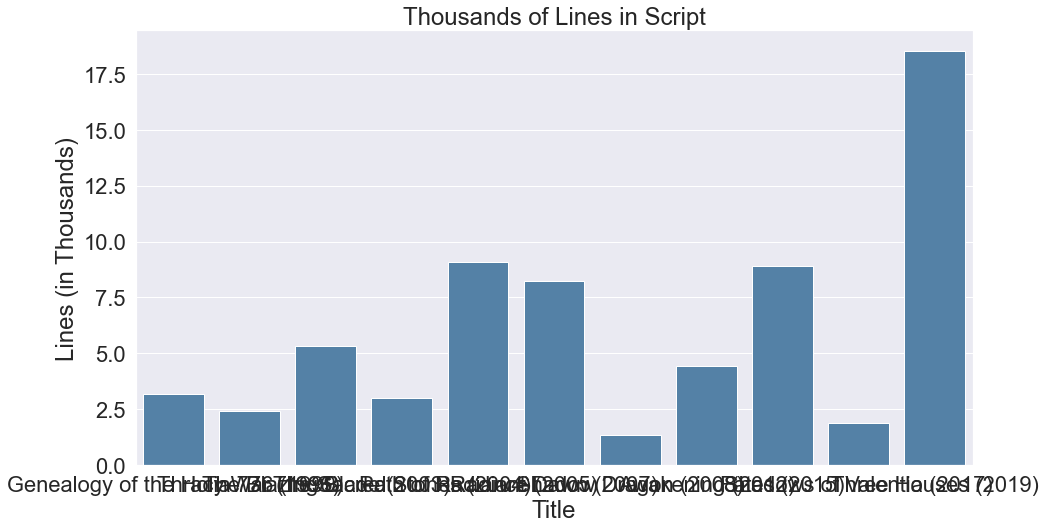

In [398]:
%matplotlib inline
sns.set(rc = {'figure.figsize':(15,8)})
sns.set_theme()
sns.set(font_scale = 2)
figure = sns.barplot(x = df_lines['title'], y = df_lines['lines']/1000, color = 'steelblue')
figure.set_title("Thousands of Lines in Script")
figure.set_ylabel('Lines (in Thousands)')
figure.set_xlabel('Title')
figure.set_xticklabels(labels = df_lines['title'], wrap=True)

*I'll just do this in Tableau...*

# Training a model to speak like Fire Emblem characters
- Load up scripts from all available games
- Find characters that speak the most
- Use Markov Chain text generation

In [501]:
all_games = [4, 5, 7, 8, 9, 10, 11, 13, 14, 15, 16]
df_all = pd.concat([pd.read_csv(f'fe{fe_num}.csv', index_col = 0) for fe_num in all_games])
df_all.sample(10)

,0
376,Enemy Soldier: ......
794,"Dimitri: You're a tough opponent, but I refuse..."
1247,Daein Soldier: Shall we continue with the plan...
5599,"Naesala: Sorry, but I changed my mind. Someone..."
3432,Linus: Will you stop yammering! I don't need m...
17828,Linhardt: Hmm… If those things were created to...
7077,It occurs to me...\n
2946,Emmeryn: Chrom... Everyone... Thank you...
1129,"Lekain: Duke Numida, my friend… I’m afraid you..."
575,Mikoto: I’m so glad…


In [502]:
df_all.columns = ['quote']
df_all['speaker'] = df_all['quote'].apply(get_speaker)
df_all['quote'] = df_all['quote'].apply(clean_script)
df_all['speaker'] = df_all['speaker'].apply(alias_check)

In [506]:
df_speaker_leaderboard = df_all.groupby(by = 'speaker', as_index = False).count().sort_values(by = 'quote', ascending = False)

In [507]:
df_speaker_leaderboard.loc[df_speaker_leaderboard['speaker'] == 'Owain']

,speaker,quote
1069,Owain,74


In [508]:
relevant_speakers = ['Sain', 'Hector', 'Corrin', 'Celica', 'Eirika', 'Lyn', 'Eliwood', 'Ike',
                     'Titania', 'Dimitri', 'Edelgard', 'Chrom', 'Bastian', 'Marth', 'Elise',
                     'Rhea', 'Azura', 'Owain']
speaker_corpus = {}
for speaker in relevant_speakers:
    corpus = []
    for quote in df_all.loc[df_all.speaker == speaker].dropna()['quote']:
        corpus.append(quote)
    speaker_corpus[speaker] = corpus

In [509]:
def markov_chain(corpus):
    for ix in range(len(corpus), -1, -1):
        corpus.insert(ix, 'line_break')
    corpus = ' '.join(corpus)
    words = corpus.split(' ')
    m_dict = defaultdict(list)
    for current_word, next_word in zip(words[:-1], words[1:]):
        m_dict[current_word].append(next_word)
    m_dict = dict(m_dict)
    
    return m_dict

In [510]:
vocab = {}
for speaker in relevant_speakers:
    vocab[speaker] = markov_chain(speaker_corpus[speaker])

In [511]:
def generate_sentence(quote_dict):
    word1 = 'line_break'
    sentence = word1
    
    while True:
        word2 = random.choice(quote_dict[word1])
        word1 = word2
        sentence += ' ' + word2
        if (word2[-1] in '.!?') and (random.randint(0,1) == 0):
            break
    sentence = sentence.strip('/[]><+=\\')
    return sentence.replace('line_break ', '')

In [582]:
for speaker in ['Hector', 'Celica', 'Titania', 'Chrom', 'Edelgard']:
    for _ in range(10):
        print(speaker + ': ' + generate_sentence(vocab[speaker]))

Hector: Listen up, you want to be attacked.
Hector: What is strange. We've an assassination attempt on forever...
Hector: He's traveling in two. Who--!? You do now? We do you to the border.
Hector: Huh?
Hector: Oswin? Have you talking to make sure he is the castle?
Hector: I see.
Hector: Old man! Huh?
Hector: Come on! Wait a firm believer in here! Whew... I thought you want the sake of Bern’s might have a grudge against Ostia.
Hector: If a contemptuous peacock. He's slaughtered our ancestors dedicated themselves to meet. Stay right now. Save it so.
Hector: She looks like. Come on!
Celica: He's not dismissing what happened. Because it’s me!
Celica: If we must know we can prevail.
Celica: Wait a manly wreath when people of way.
Celica: Hmm… No. We find something of your being routinely plundered.
Celica: Alm even if we just that you?
Celica: Alm… This isn't possible!
Celica: I’m going on? Can't you as barren fields have invaded… I don't leave these waters at that, I... I get a boy with g

IndexError: string index out of range